<center><font size=6>Project Overview</center>

## Problem:
>Hospitals often experience inefficient bed utilization due to delays in patient admissions, prolonged length of stay, and slow discharge or turnaround processes. These bottlenecks cause beds and associated resources to remain idle, limiting patient throughput and affecting operational efficiency.

## Solution:
>This project analyzes historical admission, length of stay, and discharge data to identify operational delays across clinical review, documentation, housekeeping, and patient transfer stages. A predictive LOS model and bed occupancy forecasting logic are implemented to estimate real-time and future bed availability, enabling proactive planning and improved patient flow management.

## Impact:
>The solution improves bed turnover rates, reduces idle resource time, enhances patient admission capacity, and supports data-driven operational decisions—leading to increased revenue potential and better overall hospital efficiency.

# Importing Liabraries

In [1]:
!pip install sodapy

In [2]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import psycopg2
from psycopg2.extras import execute_values
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Fetching Data using API Key --> python df

In [3]:
API_TOKEN=" ************** "
DATASET_ID = "u4ud-w55t"


In [5]:
from sodapy import Socrata
import json
client = Socrata("health.data.ny.gov",API_TOKEN,timeout=60)


results = client.get("u4ud-w55t", limit=2)
print(json.dumps(results, indent=2))

[
  {
    "hospital_service_area": "Capital/Adirond",
    "hospital_county": "Albany",
    "operating_certificate_number": "0101000",
    "facility_id": "1",
    "facility_name": "Albany Medical Center Hospital",
    "age_group": "0 to 17",
    "zip_code_3_digits": "121",
    "gender": "F",
    "race": "Other Race",
    "ethnicity": "Not Span/Hispanic",
    "length_of_stay": "1",
    "type_of_admission": "Urgent",
    "patient_disposition": "Home or Self Care",
    "discharge_year": "2012",
    "ccs_diagnosis_code": "128",
    "ccs_diagnosis_description": "Asthma",
    "ccs_procedure_code": "000",
    "ccs_procedure_description": "NO PROC",
    "apr_drg_code": "141",
    "apr_drg_description": "Asthma",
    "apr_mdc_code": "04",
    "apr_mdc_description": "Diseases and Disorders of the Respiratory System",
    "apr_severity_of_illness_code": "2",
    "apr_severity_of_illness_description": "Moderate",
    "apr_risk_of_mortality": "Minor",
    "apr_medical_surgical_description": "Medical

In [6]:
SELECTED_COLUMNS = [
    "hospital_service_area",
    "hospital_county",
    "operating_certificate_number",
    "facility_id",
    "facility_name",
    "age_group",
    "zip_code_3_digits",
    "gender",
    "length_of_stay",
    "type_of_admission",
    "patient_disposition",
    "apr_mdc_code",
    "apr_mdc_description",
    "ccs_diagnosis_code",
    "ccs_diagnosis_description",
    "ccs_procedure_code",
    "ccs_procedure_description",
    "apr_drg_code",
    "apr_drg_description",
    "apr_severity_of_illness_code",
    "apr_severity_of_illness_description",
    "apr_risk_of_mortality",
    "apr_medical_surgical_description",
    "abortion_edit_indicator",
    "emergency_department_indicator",
    "total_charges",
    "total_costs",
]
SELECT_SOQL = ", ".join(SELECTED_COLUMNS)

In [7]:

client = Socrata("health.data.ny.gov",API_TOKEN,
    timeout=60)

LIMIT = 50000
TOTAL = 250000

all_data = []

for offset in range(0, TOTAL, LIMIT):
    results = client.get(DATASET_ID, limit=LIMIT, offset=offset,select=SELECT_SOQL )
    all_data.extend(results)

df = pd.DataFrame(all_data)
print("Done. Rows:", len(df))


Done. Rows: 250000


# columns renaming and standardizing datatypes

In [8]:
df = df.rename(columns={
    "gender": "gender",
    "age_group": "age_grp",
    "facility_id": "facility_id",
    "total_costs": "tot_cost",
    "apr_drg_code": "drug_code",
    "facility_name": "facility_name",
    "total_charges": "tot_charges",
    "discharge_year": "dis_year",
    "length_of_stay": "los",
    "hospital_county": "county",
    "type_of_admission": "admission_type",
    "zip_code_3_digits": "zip3",
    "ccs_diagnosis_code": "diag_code",
    "ccs_procedure_code": "proc_code",
    "apr_mdc_code": "mdc_diag_code",
    "apr_mdc_description": "mdc_diag_desc",
    "apr_drg_description": "drug_desc",
    "patient_disposition": "patient_disposition",
    "apr_risk_of_mortality": "mortality_risk",
    "hospital_service_area": "service_area",
    "abortion_edit_indicator": "abort_ind",
    "ccs_diagnosis_description": "diag_desc",
    "ccs_procedure_description": "procedure_desc",
    "apr_severity_of_illness_code": "severity_illness_code",
    "operating_certificate_number": "cert_no",
    "emergency_department_indicator": "emergency_dept_ind",
    "apr_medical_surgical_description": "med_surg_desc",
    "apr_severity_of_illness_description": "severity_desc"
})


In [9]:
dtype_map = {
    "service_area": "string",
    "county": "string",
    "cert_no": "string",
    "facility_id": "string",
    "facility_name": "string",
    "age_grp": "string",
    "zip3": "string",
    "gender": "string",
    "admission_type": "string",
    "patient_disposition": "string",
    "diag_code": "string",
    "diag_desc": "string",
    "mdc_diag_code": "string",
    "mdc_diag_desc": "string",
    "proc_code": "string",
    "procedure_desc": "string",
    "drug_code": "string",
    "drug_desc": "string",
    "severity_illness_code": "Int8",
    "severity_desc": "string",
    "mortality_risk": "string",
    "med_surg_desc": "string",
    "abort_ind": "string",
    "emergency_dept_ind": "string",
    "tot_charges": "float32",
    "tot_cost": "float32",
}
df = df.astype(dtype_map)

In [10]:
df["los"] = df["los"].astype(str).str.extract(r'(\d+)')
df["los"] = pd.to_numeric(df["los"], errors="coerce").astype('Int16')

In [11]:
df.to_csv("hospital_data_250k_clean.csv", index=False,quoting=1)

# Connecting to Postgresql and loading CSV file into a database

In [171]:
conn = psycopg2.connect(
    host="ep-weathered-hat-a4ybwu9r-pooler.us-east-1.aws.neon.tech",
    dbname="neondb",
    user="neondb_owner",
    password="npg_P6r5UTgIjYzF",
    sslmode="require")

cursor = conn.cursor()

with open("hospital_data_250k_clean.csv", "r", encoding="utf-8") as f:
    cursor.copy_expert(
        """
        COPY hospital_data
        FROM STDIN
        WITH CSV HEADER
        """,
        file=f
    )

conn.commit()
cursor.close()
conn.close()

print("CSV imported successfully!")

CSV imported successfully!


<center><font size='16'>Data Cleaning for Feature Engineering</font></center>

In [12]:
df['age_grp'].unique()

<StringArray>
['0 to 17', '18 to 29', '70 or Older', '30 to 49', '50 to 69']
Length: 5, dtype: string

In [13]:
df_enhanced = df.copy()

##age group features

In [14]:
print("\n1. Engineering Age Features...")
age_mapping = {
        '0 to 17': 8.5,
        '18 to 29': 23.5,
        '30 to 49': 39.5,
        '50 to 69': 59.5,
        '70 or Older': 77.5
    }
df_enhanced['Age_Numeric'] = df_enhanced['age_grp'].map(age_mapping)
df_enhanced['Is_Elderly'] = (df_enhanced['age_grp'] == '70 or Older').astype(int)
df_enhanced['Is_Pediatric'] = (df_enhanced['age_grp'] == '0 to 17').astype(int)



1. Engineering Age Features...


## "admission_type" categories into binary signals


In [15]:
df['admission_type'].unique()

<StringArray>
['Urgent', 'Emergency', 'Elective', 'Newborn', 'Not Available', 'Trauma']
Length: 6, dtype: string

In [16]:
df_enhanced['admission_type'] = df_enhanced['admission_type'].str.strip()

admission_mapping = {
    'Emergency': 'Is_Emergency',
    'Elective': 'Is_Elective',
    'Urgent': 'Is_Urgent',
    'Newborn': 'Is_Newborn',
    'Not Available': 'Is_NotAvailable',
    'Trauma': 'Is_Trauma'
}
for category, new_col in admission_mapping.items():
    df_enhanced[new_col] = (df_enhanced['admission_type'] == category).astype(int)

In [17]:
df['severity_desc'].unique()

<StringArray>
['Moderate', 'Minor', 'Major', 'Extreme', <NA>]
Length: 5, dtype: string

## "severity_desc" categories already has codes for it in integer

In [18]:
df.groupby(['severity_desc', 'severity_illness_code']).size().reset_index(name='count')


,severity_desc,severity_illness_code,count
0,Extreme,4,18315
1,Major,3,60549
2,Minor,1,78108
3,Moderate,2,93020


In [19]:
df[['severity_desc', 'severity_illness_code']].drop_duplicates()


,severity_desc,severity_illness_code
0,Moderate,2
1,Minor,1
7,Major,3
19,Extreme,4
3629,<NA>,0


In [20]:
df['severity_desc'].isnull()

,severity_desc
0,False
1,False
2,False
3,False
4,False
...,...
249995,False
249996,False
249997,False
249998,False


## Medical or Surgical code

In [21]:
df.groupby(['med_surg_desc']).size().reset_index()

,med_surg_desc,0
0,Medical,186242
1,Not Applicable,8
2,Surgical,63750


In [22]:
df_enhanced['Is_medical'] = (df_enhanced['med_surg_desc'] == 'Medical').astype(int)
df_enhanced['Is_surgical'] = (df_enhanced['med_surg_desc'] == 'Surgical').astype(int)
df_enhanced['Is_not_applicable'] = (df_enhanced['med_surg_desc'] == 'Not Applicable').astype(int)

## for emergency dept indicator('Y' / 'N') --> 'Came_through_ED'(1/0)
## emergency_dept_ind suggests
> Y -- patient went through ED

> N -- patient didnt go though ED
## but Is_emergency (1/0) suggest , the patiencs admission type ('Emergency')

In [23]:
#went to Ed or not
df_enhanced['Came_Through_ED'] = (df_enhanced['emergency_dept_ind'] == 'Y').astype(int)

In [24]:
# went to ED or Is_Emergency or Both or None (multiplying for AND operation)
df_enhanced['Emergency_And_ED'] = df_enhanced['Is_Emergency'] * df_enhanced['Came_Through_ED']



##Why multiply? Why create Emergency_And_ED?
>Because:
"Emergency case" ≠ "Came from ED"
>These are two different but related signals

>The multiplication tells the model:
- This patient is an actual emergency case AND they entered via the Emergency Department.
- This can improve prediction accuracy for LOS (length of stay).

In [25]:
##aggregatinh los , by grouping "DRUG CODE"


drg_stats = df_enhanced.groupby('drug_code')['los'].agg(['mean', 'median', 'std']).reset_index()
drg_stats.columns = ['DRG_code', 'DRG_Avg_LOS', 'DRG_Median_LOS', 'DRG_Std_LOS']
df_enhanced = df_enhanced.merge(drg_stats, left_on='drug_code', right_on='DRG_code', how='left')

In [26]:
## aggregating los, grouping by "CCS DIAGNOSTIC CATEGORY CODE"

CCS_stats = df_enhanced.groupby('diag_code')['los'].agg(['mean', 'median']).reset_index()
CCS_stats.columns = ['diag_code', 'diag_Avg_LOS', 'diag_Median_LOS']
df_enhanced = df_enhanced.merge(CCS_stats, on='diag_code', how='left')


In [27]:
## aggregating los, grouping by "APR MDC CODE or MEDICAL DIAGNOSTIC CATEGORY CODE"

mdc_diag_stats = df_enhanced.groupby('mdc_diag_code')['los'].agg(['mean', 'median']).reset_index()
mdc_diag_stats.columns = ['mdc_diag_code', 'mdc_diag_Avg_LOS', 'mdc_diag_Median_LOS']
df_enhanced = df_enhanced.merge(mdc_diag_stats, on='mdc_diag_code', how='left')


In [28]:
## aggregating los, grouping by "FACILITY NAME"

facility_stats = df_enhanced.groupby('facility_name')['los'].agg(['mean', 'median']).reset_index()
facility_stats.columns = ['facility_name', 'Facility_Avg_LOS', 'Facility_Median_LOS']
df_enhanced = df_enhanced.merge(facility_stats, on='facility_name', how='left')


In [29]:
df_enhanced['Cost_Per_Day_Historic'] = df_enhanced['tot_cost'] / df_enhanced['los']
df_enhanced['Cost_Per_Day_Historic'] = df_enhanced['Cost_Per_Day_Historic'].replace([np.inf, -np.inf], np.nan)
df_enhanced['Charge_to_Cost_Ratio'] = df_enhanced['tot_charges'] / (df_enhanced['tot_cost'] + 1)
df_enhanced['Log_Total_Charges'] = np.log1p(df_enhanced['tot_charges'].fillna(0))


In [30]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical(df):
    df_encoded = df.copy()
    label_encoders = {}

    # Your actual categorical features
    categorical_features = [
        'gender',
         'mortality_risk',
        'patient_disposition',
        'mdc_diag_desc',
        'diag_desc',
        'procedure_desc',
        'drug_desc',
        'service_area',
        'facility_name',
        'county'
    ]

    for feature in categorical_features:
        if feature in df.columns:
            le = LabelEncoder()
            df_encoded[f'{feature}_encoded'] = le.fit_transform(
                df_encoded[feature].fillna('Unknown')
            )
            label_encoders[feature] = le
            print(f"✓ Encoded {feature}")

    return df_encoded, label_encoders
df_enhanced, label_encoders = encode_categorical(df_enhanced)

✓ Encoded gender
✓ Encoded mortality_risk
✓ Encoded patient_disposition
✓ Encoded mdc_diag_desc
✓ Encoded diag_desc
✓ Encoded procedure_desc
✓ Encoded drug_desc
✓ Encoded service_area
✓ Encoded facility_name
✓ Encoded county


<center><font size='6'>Gradient Boosting Regressor</center>

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [32]:
def train_enhanced_model(df):
    """Train enhanced Gradient Boosting model with rich features (adapted to df_enhanced)."""
    print("\n" + "="*70)
    print("TRAINING ENHANCED ML MODEL")
    print("="*70)

    feature_columns = [
        'gender_encoded',
        'mortality_risk_encoded',
        'patient_disposition_encoded',
        'mdc_diag_desc_encoded',
        'diag_desc_encoded',
        'procedure_desc_encoded',
        'drug_desc_encoded',
        'service_area_encoded',
        'facility_name_encoded',
        'county_encoded',

        'severity_illness_code',

        'mdc_diag_Avg_LOS',
        'mdc_diag_Median_LOS',
        'Facility_Avg_LOS',
        'Facility_Median_LOS',

        'Cost_Per_Day_Historic',
        'Charge_to_Cost_Ratio',
        'Log_Total_Charges',

        'tot_charges',
        'tot_cost'
    ]

    available_features = [f for f in feature_columns if f in df.columns]

    print(f"\nUsing {len(available_features)} features for training:")

    for f in available_features:
        print("  -", f)

    df_model = df.dropna(subset=['los']).copy()

    print(f"\nTraining rows available: {len(df_model):,}")

    for col in available_features:
        if df_model[col].isna().any():
            median_val = df_model[col].median()
            df_model[col] = df_model[col].fillna(median_val)
            print(f"  Filled missing in {col} with median = {median_val}")

    X = df_model[available_features]
    y = df_model['los']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42
    )
    print(f"\nSplit: {len(X_train):,} train rows, {len(X_test):,} test rows")

    print("\nTraining Gradient Boosting Regressor with tuned hyperparameters...")

    model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=8,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        max_features='sqrt',
        random_state=42,
        verbose=0
    )

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    print(f"\n{'='*70}")
    print("MODEL PERFORMANCE")
    print(f"{'='*70}")
    print(f"\nTraining Set:\n  MAE: {train_mae:.2f} days\n  R²: {train_r2:.3f}")
    print(f"\nTest Set:\n  MAE: {test_mae:.2f} days\n  RMSE: {rmse:.2f} days\n  R²: {test_r2:.3f}")

    errors = np.abs(y_test - y_pred_test)
    within_1 = (errors <= 1).sum() / len(errors) * 100
    within_2 = (errors <= 2).sum() / len(errors) * 100
    within_3 = (errors <= 3).sum() / len(errors) * 100

    print(f"\nPrediction Accuracy:\n  Within ±1 day: {within_1:.1f}%\n  Within ±2 days: {within_2:.1f}%\n  Within ±3 days: {within_3:.1f}%")

    fi = pd.DataFrame({
        'Feature': available_features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False).reset_index(drop=True)

    print(f"\n{'='*70}\nTOP FEATURES\n{'='*70}")
    for idx, row in fi.head(15).iterrows():
        print(f"  {idx+1:02d}. {row['Feature']:<35} {row['Importance']:.4f}")

    return model, available_features


In [33]:
def add_predictions(df, model, feature_columns):
    """Add predicted LOS to dataframe (df must include the same feature columns)."""
    print("\n" + "="*70)
    print("GENERATING PREDICTIONS")
    print("="*70)

    df_pred = df.copy()

    for col in feature_columns:
        if col not in df_pred.columns:
            raise ValueError(f"Feature column missing from dataframe: {col}")
        if df_pred[col].isna().any():
            median_val = df_pred[col].median()
            df_pred[col] = df_pred[col].fillna(median_val)
            print(f"  Filled missing in {col} with median = {median_val}")


    has_features = df_pred[feature_columns].notna().all(axis=1)
    X = df_pred.loc[has_features, feature_columns]

    predictions = model.predict(X)

    df_pred['Predicted_LOS'] = np.nan
    df_pred.loc[has_features, 'Predicted_LOS'] = predictions

    df_pred['Predicted_LOS'] = df_pred['Predicted_LOS'].clip(lower=0.5)
    df_pred['Predicted_LOS'] = df_pred['Predicted_LOS'].round(1)

    print(f"✓ Generated predictions for {has_features.sum():,} records")
    return df_pred


## model training starts here

In [34]:
df_enhanced.head()

,service_area,county,cert_no,facility_id,facility_name,age_grp,zip3,gender,los,admission_type,...,gender_encoded,mortality_risk_encoded,patient_disposition_encoded,mdc_diag_desc_encoded,diag_desc_encoded,procedure_desc_encoded,drug_desc_encoded,service_area_encoded,facility_name_encoded,county_encoded
0,Capital/Adirond,Albany,0101000,1,Albany Medical Center Hospital,0 to 17,121,F,1,Urgent,...,0,2,7,12,19,115,15,0,1,0
1,Capital/Adirond,Albany,0101000,1,Albany Medical Center Hospital,0 to 17,121,F,1,Emergency,...,0,2,7,4,1,115,0,0,1,0
2,Capital/Adirond,Albany,0101000,1,Albany Medical Center Hospital,18 to 29,120,F,3,Urgent,...,0,2,7,24,84,115,263,0,1,0
3,Capital/Adirond,Albany,0101000,1,Albany Medical Center Hospital,18 to 29,121,F,2,Elective,...,0,2,7,24,221,24,40,0,1,0
4,Capital/Adirond,Albany,0101000,1,Albany Medical Center Hospital,70 or Older,124,M,3,Elective,...,1,3,7,4,234,70,255,0,1,0


In [35]:
model, features = train_enhanced_model(df_enhanced)


TRAINING ENHANCED ML MODEL

Using 20 features for training:
  - gender_encoded
  - mortality_risk_encoded
  - patient_disposition_encoded
  - mdc_diag_desc_encoded
  - diag_desc_encoded
  - procedure_desc_encoded
  - drug_desc_encoded
  - service_area_encoded
  - facility_name_encoded
  - county_encoded
  - severity_illness_code
  - mdc_diag_Avg_LOS
  - mdc_diag_Median_LOS
  - Facility_Avg_LOS
  - Facility_Median_LOS
  - Cost_Per_Day_Historic
  - Charge_to_Cost_Ratio
  - Log_Total_Charges
  - tot_charges
  - tot_cost

Training rows available: 250,000

Split: 200,000 train rows, 50,000 test rows

Training Gradient Boosting Regressor with tuned hyperparameters...

MODEL PERFORMANCE

Training Set:
  MAE: 0.21 days
  R²: 0.997

Test Set:
  MAE: 0.25 days
  RMSE: 0.77 days
  R²: 0.990

Prediction Accuracy:
  Within ±1 day: 96.5%
  Within ±2 days: 98.9%
  Within ±3 days: 99.4%

TOP FEATURES
  01. tot_cost                            0.3008
  02. Cost_Per_Day_Historic               0.1953
  0

In [36]:
df_with_preds = add_predictions(df_enhanced, model, features)



GENERATING PREDICTIONS
✓ Generated predictions for 250,000 records


## questions on los

Which diagnoses have the longest LOS?

Which procedure combinations lead to delays?

Which departments (service_area) have the highest bed-blocking?

Which admission types cause most delays?

Which age groups stay longer?

# 1.Which diagnoses have the longest LOS?

In [37]:
df.groupby('diag_desc')['los'].mean().sort_values(ascending=False).reset_index().head(10)

,diag_desc,los
0,Respiratory distress syndrome,31.030928
1,Short gestation; low birth weight; and fetal g...,26.720588
2,Other CNS infection and poliomyelitis,17.217391
3,Schizophrenia and other psychotic disorders,15.473124
4,Rehabilitation care; fitting of prostheses; an...,14.879404
5,Leukemias,14.005102
6,Gangrene,13.065306
7,Multiple myeloma,12.838235
8,Intrauterine hypoxia and birth asphyxia,12.777778
9,Chronic ulcer of skin,12.144928


# 2.Which procedure combinations lead to highest number of delays?

In [38]:
df_with_preds['delay'] = df_with_preds['los'] - df_with_preds['Predicted_LOS']
df_with_preds['delay_hours'] = df_with_preds['delay'] * 24

df_with_preds.groupby(['med_surg_desc','procedure_desc'])['delay'].size().sort_values(ascending=False).head(20)

med_surg_desc  procedure_desc         
Medical        NO PROC                    85585
               OTHER THERAPEUTIC PRCS      8196
               CIRCUMCISION                7945
Surgical       CESAREAN SECTION            7332
Medical        ALCO/DRUG REHAB/DETOX       7002
               OT PRCS TO ASSIST DELIV     6643
               RESP INTUB/MECH VENTIL      6543
               PROPHYLACTIC VAC/INOCUL     5847
Surgical       ARTHROPLASTY KNEE           5278
Medical        BLOOD TRANSFUSION           4982
Surgical       HIP REPLACEMENT,TOT/PRT     3985
               SPINAL FUSION               3923
Medical        REPAIR CUR OBS LACERATN     3909
               UP GASTRO ENDOSC/BIOPSY     3411
               DX CARDIAC CATHETERIZTN     3218
Surgical       PERC TRANSLUM COR ANGIO     3210
Medical        PHYS THER EXER, MANIPUL     3047
               OT VASC CATH; NOT HEART     2931
               DX ULTRASOUND HEART         2327
               HEMODIALYSIS                2220
Name: delay, dtype: Int64

#3.Which service_area have the highest delays?

In [39]:
df_with_preds.groupby('service_area')['delay'].size().sort_values(ascending=False)

,delay
service_area,
Capital/Adirond,78995
Western NY,78459
Hudson Valley,32277
Southern Tier,31849
Finger Lakes,16735
Central NY,11685


#4.Which admission types cause longest bed blockings (in days) ?

In [40]:
df.groupby('admission_type')['los'].mean().round().sort_values(ascending=False).reset_index()

,admission_type,los
0,Not Available,8.0
1,Emergency,6.0
2,Urgent,6.0
3,Elective,5.0
4,Newborn,4.0
5,Trauma,4.0


#5.Which age groups stay longer?

In [41]:
df.groupby('age_grp')['los'].median().sort_values(ascending=False).reset_index()

,age_grp,los
0,70 or Older,4.0
1,30 to 49,3.0
2,18 to 29,3.0
3,50 to 69,3.0
4,0 to 17,2.0


In [42]:
age_group_los = df.groupby('age_grp')['los'].median().sort_values(ascending=False).reset_index()

fig = px.bar(
    age_group_los,
    x='age_grp',
    y='los',
    title='Age group with longest LOS',
    labels={'age_grp': 'Age Group', 'los': 'Median of Length of Stay (Days)'},
    color='los',
    color_continuous_scale=px.colors.sequential.Plasma
)

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

## 6.Which Diagnosis Categories cause the longest delay ?

In [43]:
delay_diag = (
    df_with_preds.groupby('diag_desc')['delay']
    .mean()
    .sort_values(ascending=False)
).head(10)


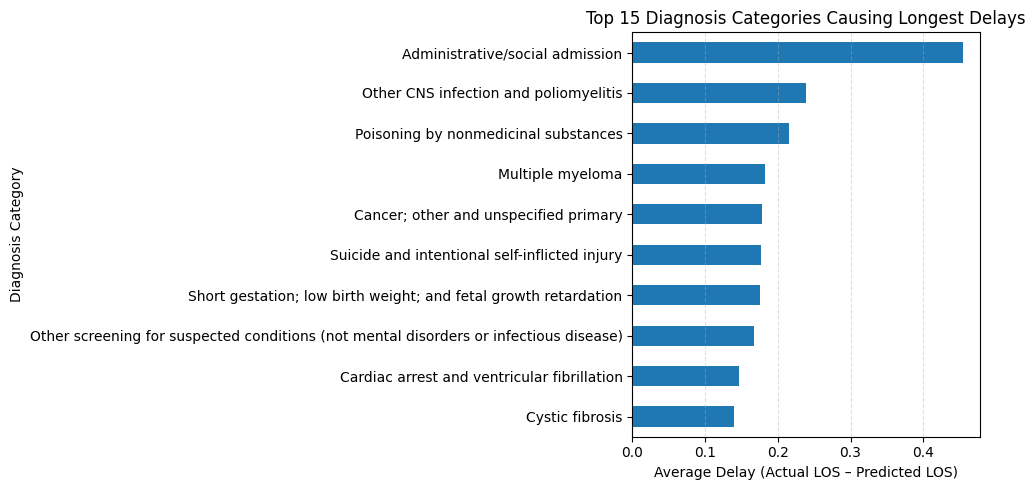

In [44]:
plt.figure(figsize=(10, 5))
delay_diag.sort_values().plot(kind='barh')

plt.title('Top 15 Diagnosis Categories Causing Longest Delays')
plt.xlabel('Average Delay (Actual LOS – Predicted LOS)')
plt.ylabel('Diagnosis Category')
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

>  Administrative or Social Admissions represent non-clinical admissions driven ?by documentation delays, insurance approvals, caregiver unavailability, or social circumstances. These patients are medically stable, but remain admitted for non-medical reasons, making this the highest contributor to preventable delays and bed-blocking.

## 7.Which medication combination lead to longer los?

In [45]:
longer_los_drug = (
    df_with_preds.groupby('drug_desc')['Predicted_LOS']
    .mean()
    .sort_values(ascending=False)
).head(10)

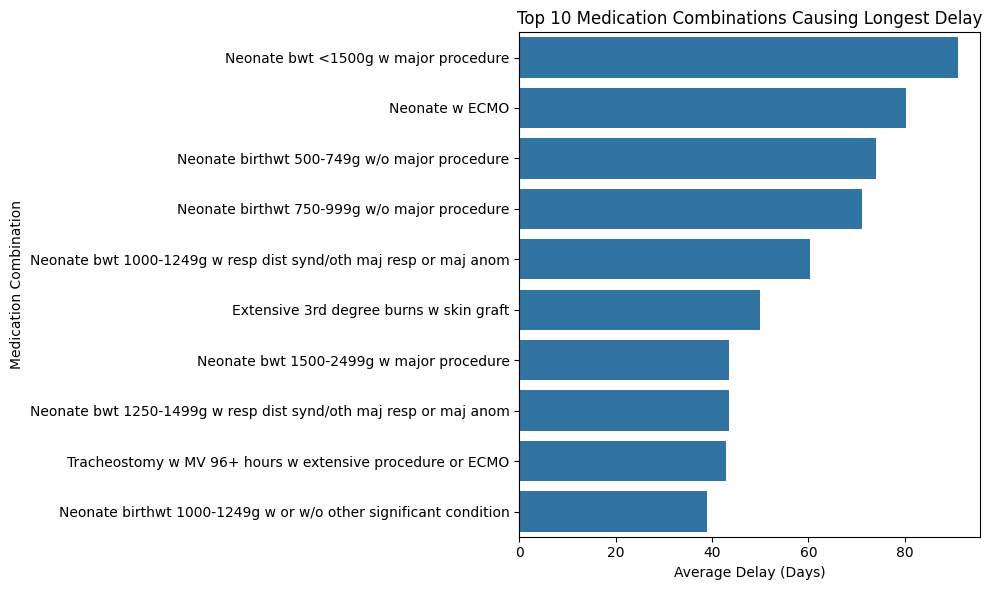

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=longer_los_drug.values,
    y=longer_los_drug.index,
    orient='h'
)
plt.xlabel("Average Delay (Days)")
plt.ylabel("Medication Combination")
plt.title("Top 10 Medication Combinations Causing Longest Delay")
plt.tight_layout()
plt.show()

## 8.Which medication combinations causes longest delay in each Admission Type

In [47]:
delay_data = (
    df_with_preds.groupby(['admission_type', 'drug_desc'])['delay']
    .size()
    .reset_index()
).sort_values(by='delay', ascending=False)


In [48]:
top5 = (
    delay_data.sort_values(["admission_type", "delay"], ascending=[True, False])
         .groupby("admission_type")
         .head(5)
)

In [49]:
import plotly.graph_objects as go

drug_categories = delay_data['drug_desc'].unique()
admission_types = delay_data['admission_type'].unique()

fig = go.Figure()


for drug in drug_categories:
    subset = top5[top5['drug_desc'] == drug]

    fig.add_trace(go.Bar(
        x=subset['admission_type'],
        y=subset['delay'],
        name=drug,
        hovertemplate=
            "<b>Admission Type:</b> %{x}<br>" +
            "<b>Drug Description:</b> " + drug + "<br>" +
            "<b>no. of Delays:</b> %{y:.2f}<br>" +
            "<extra></extra>",
    ))

fig.update_layout(
    barmode='stack',
    width=1100,
    height=700,
    title="Highest Delay by Admission Type & Drug Description",
    xaxis_title="Admission Type",
    yaxis_title="Average Delay (Days)",
    showlegend=False
)

fig.show()

# Predicting Admission-time Bed occupancy number

## step-1 :creating a demo data (without los)

In [51]:
mdc_diag_desc_list=df_enhanced['mdc_diag_desc'].unique()

In [52]:
diag_desc_list =df_enhanced['diag_desc'].unique()
drug_desc_list =df_enhanced['drug_desc'].unique()
procedure_desc_list =df_enhanced['procedure_desc'].unique()
service_area_list =df_enhanced['service_area'].unique()
facility_name_list =df_enhanced['facility_name'].unique()
county_list =df_enhanced['county'].unique()

In [53]:
def create_full_raw_demo_data(n=50):
    np.random.seed(42)

    df = pd.DataFrame({
        "patient_id": [f"P{i:03d}" for i in range(1, n+1)],

        "gender": np.random.choice(["M", "F"], n),
        "age_grp": np.random.choice([
            "0 to 17",
            "18 to 29",
            "30 to 49",
            "50 to 69",
            "70 or Older"
        ], n),
        "admission_type": np.random.choice([
            "Emergency",
            "Elective",
            "Urgent",
            "Newborn",
            "Not Available",
            "Trauma"
        ], n),
        "mortality_risk": np.random.choice(["Minor", "Moderate", "Major", "Extreme"], n),
        "patient_disposition": np.random.choice(["Home", "Transfer", "Expired"], n),
        "mdc_diag_desc": np.random.choice(mdc_diag_desc_list, n),
        "diag_desc": np.random.choice(diag_desc_list, n),
        "procedure_desc": np.random.choice(procedure_desc_list, n),
        "drug_desc": np.random.choice(drug_desc_list, n),
        "service_area": np.random.choice(service_area_list, n),
        "facility_name": np.random.choice(facility_name_list, n),
        "country": np.random.choice(county_list , n),
        "med_surg_desc": np.random.choice(["Medical", "Surgical", "Not Applicable"], n),
        "emergency_dept_ind": np.random.choice(["Y", "N"], n),

        # numeric raw fields
        "severity_illness_code": np.random.randint(0, 5, n),

        # forecasting-required
        "admission_date": pd.date_range(start="2025-01-01", periods=n, freq="D")
    })

    df["predicted_los"] = np.nan
    df["discharge_date"] = np.nan

    return df

df_demo = create_full_raw_demo_data()
df_demo['diag_code']=df_demo.merge(df_enhanced[['diag_desc','diag_code']],on='diag_desc',how='left')['diag_code']
df_demo['procedure_code']=df_demo.merge(df_enhanced[['procedure_desc','proc_code']],on='procedure_desc',how='left')['proc_code']
df_demo['drug_code']=df_demo.merge(df_enhanced[['drug_desc','drug_code']],on='drug_desc',how='left')['drug_code']
df_demo['mdc_diag_code']=df_demo.merge(df_enhanced[['mdc_diag_desc','mdc_diag_code']],on='mdc_diag_desc',how='left')['mdc_diag_code']
df_demo['mdc_diag_Avg_LOS'] = df_demo.merge(df_enhanced[['mdc_diag_code','mdc_diag_Avg_LOS']],on='mdc_diag_code',how='left')['mdc_diag_Avg_LOS']
df_demo['mdc_diag_Median_LOS'] = df_demo.merge(df_enhanced[['mdc_diag_code','mdc_diag_Median_LOS']],on='mdc_diag_code',how='left')['mdc_diag_Median_LOS']
df_demo['Facility_Avg_LOS'] = df_demo.merge(df_enhanced[['facility_name','Facility_Avg_LOS']],on='facility_name',how='left')['Facility_Avg_LOS']
df_demo['diag_Avg_LOS'] = df_demo.merge(df_enhanced[['diag_code','diag_Avg_LOS']],on='diag_code',how='left')['diag_Avg_LOS']
df_demo['Facility_Median_LOS'] = df_demo.merge(df_enhanced[['facility_name','Facility_Median_LOS']],on='facility_name',how='left')['Facility_Median_LOS']

,patient_id,gender,age_grp,admission_type,mortality_risk,patient_disposition,mdc_diag_desc,diag_desc,procedure_desc,drug_desc,...,med_surg_desc,emergency_dept_ind,severity_illness_code,admission_date,predicted_los,discharge_date,diag_code,procedure_code,drug_code,mdc_diag_code
0,P001,M,30 to 49,Not Available,Minor,Expired,Diseases and Disorders of the Musculoskeletal ...,Transient cerebral ischemia,OTHER THERAPEUTIC PRCS,Extensive 3rd degree burns w skin graft,...,Medical,Y,2,2025-01-01,NaN,NaN,112,231,841,08
1,P002,F,50 to 69,Emergency,Extreme,Expired,Diseases and Disorders of the Eye,Nonmalignant breast conditions,COLONOSCOPY AND BIOPSY,"Major stomach, esophageal & duodenal procedures",...,Medical,N,2,2025-01-02,NaN,NaN,112,231,841,08
2,P003,M,50 to 69,Not Available,Extreme,Transfer,Mental Diseases and Disorders,Nervous system congenital anomalies,DECOMP PERIPHERAL NERVE,"Neonate, birthwt >2499g w resp dist synd/oth m...",...,Surgical,N,3,2025-01-03,NaN,NaN,112,231,841,08
3,P004,M,0 to 17,Not Available,Moderate,Expired,Diseases and Disorders of the Hepatobiliary Sy...,Fracture of neck of femur (hip),OT THERAPEUTIC EAR PRCS,"Pelvic evisceration, radical hysterectomy & ot...",...,Surgical,Y,0,2025-01-04,NaN,NaN,112,231,841,08
4,P005,M,30 to 49,Emergency,Minor,Home,Diseases and Disorders of the Hepatobiliary Sy...,Maintenance chemotherapy; radiotherapy,OTHER GI DX PRCS,"Other injury, poisoning & toxic effect diagnoses",...,Not Applicable,Y,1,2025-01-05,NaN,NaN,112,231,220,08


## step2: Enhancing features in df_demo

In [56]:
ADMISSION_ENGINEERED_COLS = [
    'Is_Elderly',
    'Is_Pediatric',
    'Is_Emergency',
]

In [103]:
def add_admission_features(df):
    df = df.copy()

    cols_to_drop = [c for c in ADMISSION_ENGINEERED_COLS if c in df.columns]
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)

    age_mapping = {
    "0 to 17": 8.5,
    "18 to 29": 23.5,
    "30 to 49": 39.5,
    "50 to 69": 59.5,
    "70 or Older": 77.5
    }

    df["Age_Numeric"] = df["age_grp"].map(age_mapping)
    df['gender_encoded'] = df['gender'].map({'M': 1, 'F': 0})

    df['Is_Emergency'] = (df['admission_type'] == 'Emergency').astype(int)

    mortality_map = {
    'Minor': 1,
    'Moderate': 2,
    'Major': 3,
    'Extreme': 4
    }
    df['mortality_risk_encoded'] = df['mortality_risk'].map(mortality_map)

    return df

In [104]:
df_enhanced = add_admission_features(df_enhanced)
df_demo = add_admission_features(df_demo)

## step3: Admission-Time Training Model

In [167]:
def train_admission_los_model(df):
    print("\n" + "="*70)
    print("TRAINING ADMISSION-TIME LOS MODEL")
    print("="*70)

    feature_columns = [
        'Age_Numeric',
        'diag_code',
        'proc_code',
        'mdc_diag_code',
        'severity_illness_code',
        'mortality_risk_encoded',
        'Is_Emergency',
        'mdc_diag_Avg_LOS',
        'mdc_diag_Median_LOS',
        'diag_Avg_LOS',
         ]

    features = [f for f in feature_columns if f in df.columns]

    print(f"\nUsing {len(features)} admission-time features:")
    for f in features:
        print("  -", f)


    df_model = df.dropna(subset=['los']).copy()
    for col in features:
      if df_model[col].isna().any():
          if pd.api.types.is_numeric_dtype(df_model[col]):
              df_model[col] = df_model[col].fillna(df_model[col].median())
          else:
              df_model[col] = df_model[col].fillna(df_model[col].mode()[0])

    X = df_model[features]
    y = df_model['los']


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )


    model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    min_samples_leaf=25,
    subsample=0.85,
    random_state=42
    )
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    print("\nMODEL PERFORMANCE (Admission-time)")
    print(f"MAE : {mean_absolute_error(y_test, preds):.2f} days")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f} days")
    print(f"R²  : {r2_score(y_test, preds):.3f}")

    fi = pd.DataFrame({
        "Feature": features,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False)

    print("\nTop Predictive Features:")
    print(fi)

    return model, features

## step4: Admission-time Predicting model

In [168]:
def predict_admission_los(df, model, feature_columns):

    df_pred = df.copy()

    for col in feature_columns:
        if col not in df_pred.columns:
            df_pred[col] = 0

    # missing values
    for col in feature_columns:
        if df_pred[col].isna().any():
            df_pred[col] = df_pred[col].fillna(df_pred[col].median())


    df_pred['predicted_los'] = model.predict(df_pred[feature_columns])

    print("Admission-time LOS prediction completed successfully.")

    return df_pred

## step5: Trained the model using Past-data(df_enhanced) & Predicted LOS on present data(df_demo)

In [169]:
admission_model,adm_features = train_admission_los_model(df_enhanced)


TRAINING ADMISSION-TIME LOS MODEL

Using 10 admission-time features:
  - Age_Numeric
  - diag_code
  - proc_code
  - mdc_diag_code
  - severity_illness_code
  - mortality_risk_encoded
  - Is_Emergency
  - mdc_diag_Avg_LOS
  - mdc_diag_Median_LOS
  - diag_Avg_LOS

MODEL PERFORMANCE (Admission-time)
MAE : 2.94 days
RMSE: 6.23 days
R²  : 0.352

Top Predictive Features:
                  Feature  Importance
4   severity_illness_code    0.388601
9            diag_Avg_LOS    0.218954
2               proc_code    0.149965
0             Age_Numeric    0.066748
1               diag_code    0.058832
8     mdc_diag_Median_LOS    0.037270
5  mortality_risk_encoded    0.034142
6            Is_Emergency    0.019938
7        mdc_diag_Avg_LOS    0.017097
3           mdc_diag_code    0.008453


In [170]:
df_demo_predicted = predict_admission_los(
    df=df_demo,
    model=admission_model,
    feature_columns=adm_features)

Admission-time LOS prediction completed successfully.


# 9.Predict total Beds occupied on a target date

In [141]:
df_demo_predicted["predicted_discharge_date"] = (df_demo_predicted["admission_date"] +pd.to_timedelta(df_demo_predicted["predicted_los"], unit="D"))

In [162]:
from IPython.display import display, HTML
def beds_occupied_on(df, target_date):
    d = pd.to_datetime(target_date)
    occupied=len(df[
        (df['admission_date'] <= d) &
        (df['predicted_discharge_date'] > d)
    ])
    display(HTML(f"""
        <div style="
            background-color:#0f172a;
            color:#38bdf8;
            padding:12px;
            border-radius:8px;
            font-size:16px;
            font-weight:600;
            width: fit-content;
            box-shadow: 0 4px 10px rgba(0,0,0,0.3);
        ">
            🏥 Beds Occupied on <b>{d.date()}</b> : <span style="color:#facc15;">{occupied}</span>
        </div>
    """))
    return occupied


In [163]:
beds_occupied_on(df_demo_predicted, "2025-02-10")

5

# 10.Forecast Beds Occupancy in next 7 days

In [159]:
def bed_forecast(df, days=7):
    df = df.copy()
    start_dt = pd.to_datetime(df['admission_date']).max().normalize()

    return pd.DataFrame([
        {
            "date": start_dt + pd.Timedelta(days=i),
            "beds_occupied": beds_occupied_on(df,start_dt + pd.Timedelta(days=i))
        }
        for i in range(days)
    ])

In [160]:
forecast_df=bed_forecast(df_demo_predicted, days=7)

In [161]:
fig = px.line(
    forecast_df,
    x="date",
    y="beds_occupied",
    markers=True,
    title="Bed Occupancy Forecast (Next 7 Days)"
)

fig.show()

# 11.Which Procedure causes the highest loss because of delay in discharge / bed blocking ?

In [ ]:
df_with_preds['Charge_Per_Day_Historic'] = df_with_preds['tot_charges'] / df_with_preds['los']
df_with_preds['loss_1'] = df_with_preds['delay'] * df_with_preds['Charge_Per_Day_Historic']

In [ ]:
df_with_preds['loss_1'].sum().round()

np.float64(-74002257.0)

In [166]:
df_with_preds['loss'] = df_with_preds['delay'] * df_with_preds['Cost_Per_Day_Historic']
loss_per_procedure=df_with_preds.groupby('procedure_desc')['loss'].sum().sort_values(ascending=False).reset_index().head(10)

fig = px.bar(
    loss_per_procedure,
    x="procedure_desc",
    y="loss",
    hover_data={
        "procedure_desc": True,
        "loss": ":,.2f"
    },
    title="Top 10 Procedures Causing Highest Financial Loss",
    labels={
        "procedure_desc": "Procedure",
        "loss": "Total Loss"
    }
)

fig.update_layout(
    xaxis_title="Procedure",
    yaxis_title="Total Loss",
    hoverlabel_align="left"
)

fig.show()